In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2s
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df_list = pd.read_csv('./seattle/listings.csv')
df_cal = pd.read_csv('./seattle/calendar.csv')

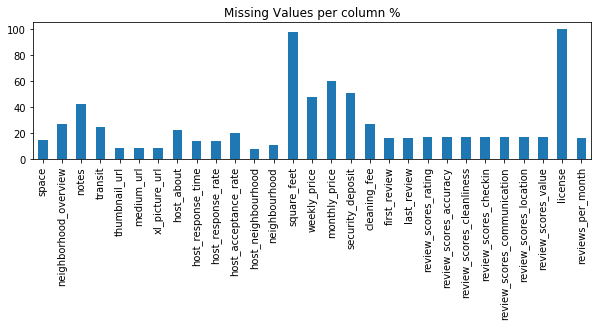

In [2]:
# Number of Missing columns values in %
plt.figure(figsize=(10,5))
df_list_nan = df_list.isnull().mean()*100
df_list_nan = df_list_nan[df_list_nan > 5]
df_list_nan.plot.bar(title='Missing Values per column %')
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig('./Images/Missing_val.jpg')

In [3]:
# Merge Calendar and Listings sheet based on listing Id
df_list = df_list.rename(columns={'id':'listing_id'})
df_data = pd.merge(df_cal, df_list, on='listing_id')

drop_cols = ['available', 'listing_url',
       'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_location',
       'host_about', 'host_acceptance_rate', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'square_feet',
       'price_y', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_license',
       'license', 'jurisdiction_names', 'reviews_per_month'] # 'neighbourhood_group_cleansed','price_x'
df_data = df_data.drop(columns=drop_cols, axis=1)

In [4]:
# function to split year, month from date 
# 0.Year (Default) 1.Month 2.Date
def get_year_from_date(row, col, val=0):
    try:
        ret = int(row[col].split('-')[val])
    except:
        ret = np.nan
        
    return ret


# function to convert percent to number along with filling NaN with Mean values
# input: Column to be converted
# output: converted column
def convert_rate2num(df):
    if df.isnull().sum()>0:
        dfa = df.str.replace("%", "").astype(float)
        dfa = dfa.fillna(dfa.mean()).astype(int)
    else:
        dfa = df.str.replace("%", "").astype(int)
        
    return dfa


# function to extract fields
def split_elem(row):
    return row.replace('{','').replace('"','').replace(' ','').replace("'","").replace('[','').replace(']','').replace('}','').split(',')

# function to extract fields and convert them to columns
def split_list_to_col(df, col, max_cols_dummies):
    values_dict ={}
    
    for row in df[col]:
        for val in split_elem(row):
            if val in values_dict:
                values_dict[val] = values_dict[val] + 1
            else:
                values_dict[val] = 0
    
    values = sorted(values_dict.items(), key= lambda kv: kv[1], reverse=True)
    for vals in values[:max_cols_dummies]:
        df[col + '_' + vals[0].replace(' ','_')] = df.apply(lambda row: 1.0 if vals[0] in split_elem(row[col]) else 0.0, axis=1)
    return

# function to convert categorical variable
def categorical_dummies(df, col, mode=True):
    if mode:
        val_na = df[col].value_counts().index[0]
    else:
        val_na = df[col].mean()
        
    if df[col].isnull().sum() > 0:
        df = pd.concat([df, pd.get_dummies(df[col].fillna(value=val_na), prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    else:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    
    return df    
    

In [5]:
# Numerical Columns
num_col = ['host_total_listings_count', 'accommodates', 'bathrooms',
           'bedrooms', 'beds', 'guests_included', 'minimum_nights',
           'maximum_nights', 'number_of_reviews', 'review_scores_rating',
           'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication',
           'review_scores_location', 'review_scores_value',
           'calculated_host_listings_count']

# Categorical Columns that will be converted to Numerical Columns
col_ohe = ['host_response_time', 'host_is_superhost',
          'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed',
          'property_type', 'room_type', 'bed_type', 'instant_bookable', 'require_guest_profile_picture',
          'cancellation_policy', 'require_guest_phone_verification']

In [6]:
def cleaning_data(df_data, num_col, col_ohe):
    
    # extract year and month from date column
    df_data['month'] = df_data.apply(lambda row: get_year_from_date(row, 'date', 1), axis=1)
    df_data['year'] = df_data.apply(lambda row: get_year_from_date(row, 'date', 0), axis=1)
    df_data = df_data.drop(columns=['date'], axis=1)
    
    # convert price_x to int and remove rows corresponding to NaN as we try to predict Price
    df_data = df_data.dropna(subset=['price_x'])
    df_data['price'] = df_data['price_x'].str.replace("[$, ]", "").astype("float")
    df_data = df_data.drop(columns=['price_x'])
    
    # convert host since and fillna
    df_data['host_since_year'] = df_data.apply(lambda row: get_year_from_date(row['host_since'], 0), axis=1)
    df_data.host_since_year.fillna(df_data['host_since_year'].mean(), inplace=True)
    df_data = df_data.drop(columns=['host_since'])

    # convert host response rate and fill NaN and drop original
    df_data['host_response_rate_num'] = convert_rate2num(df_data['host_response_rate'])
    df_data = df_data.drop(columns=['host_response_rate'])
    
    # convert host verification means and drop the original
    split_list_to_col(df_data, 'host_verifications', 7)
    df_data = df_data.drop(columns=['host_verifications'])
    
    # convert host amenities means and drop the original
    split_list_to_col(df_data, 'amenities', 10)
    df_data = df_data.drop(columns=['amenities'])
    
    # convert extra fee column to binary and delete the original
    df_data['extra_fee_bin'] = df_data.apply(lambda row: 0.0 if row['extra_people']=='$0.00' else 1.0, axis=1)
    df_data = df_data.drop(columns=['extra_people'])
    
    # convert host response time, neighbourhood_group_cleansed to one hot encoding
    # one hot encoding columns

    for col in col_ohe:
        df_data = categorical_dummies(df_data, col, mode=True)
        
    '''    
    df_data = pd.concat([df_data, pd.get_dummies(df_data['neighbourhood_group_cleansed'], 
                                                 prefix='ngc', 
                                                 prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    '''
    
    
    for col in num_col:
        if df_data[col].isnull().sum() > 0:
            df_data[col] = df_data[col].fillna(df_data[col].mean())
            
    df_data.rename(columns=lambda x:x.replace(' ', '_'), inplace=True)
    return df_data

    

df_data = cleaning_data(df_data, num_col, col_ohe)
df_data.to_csv('data_combined.csv', header=True, index=True)

In [ ]:
df_data = pd.read_csv('./data_combined.csv')

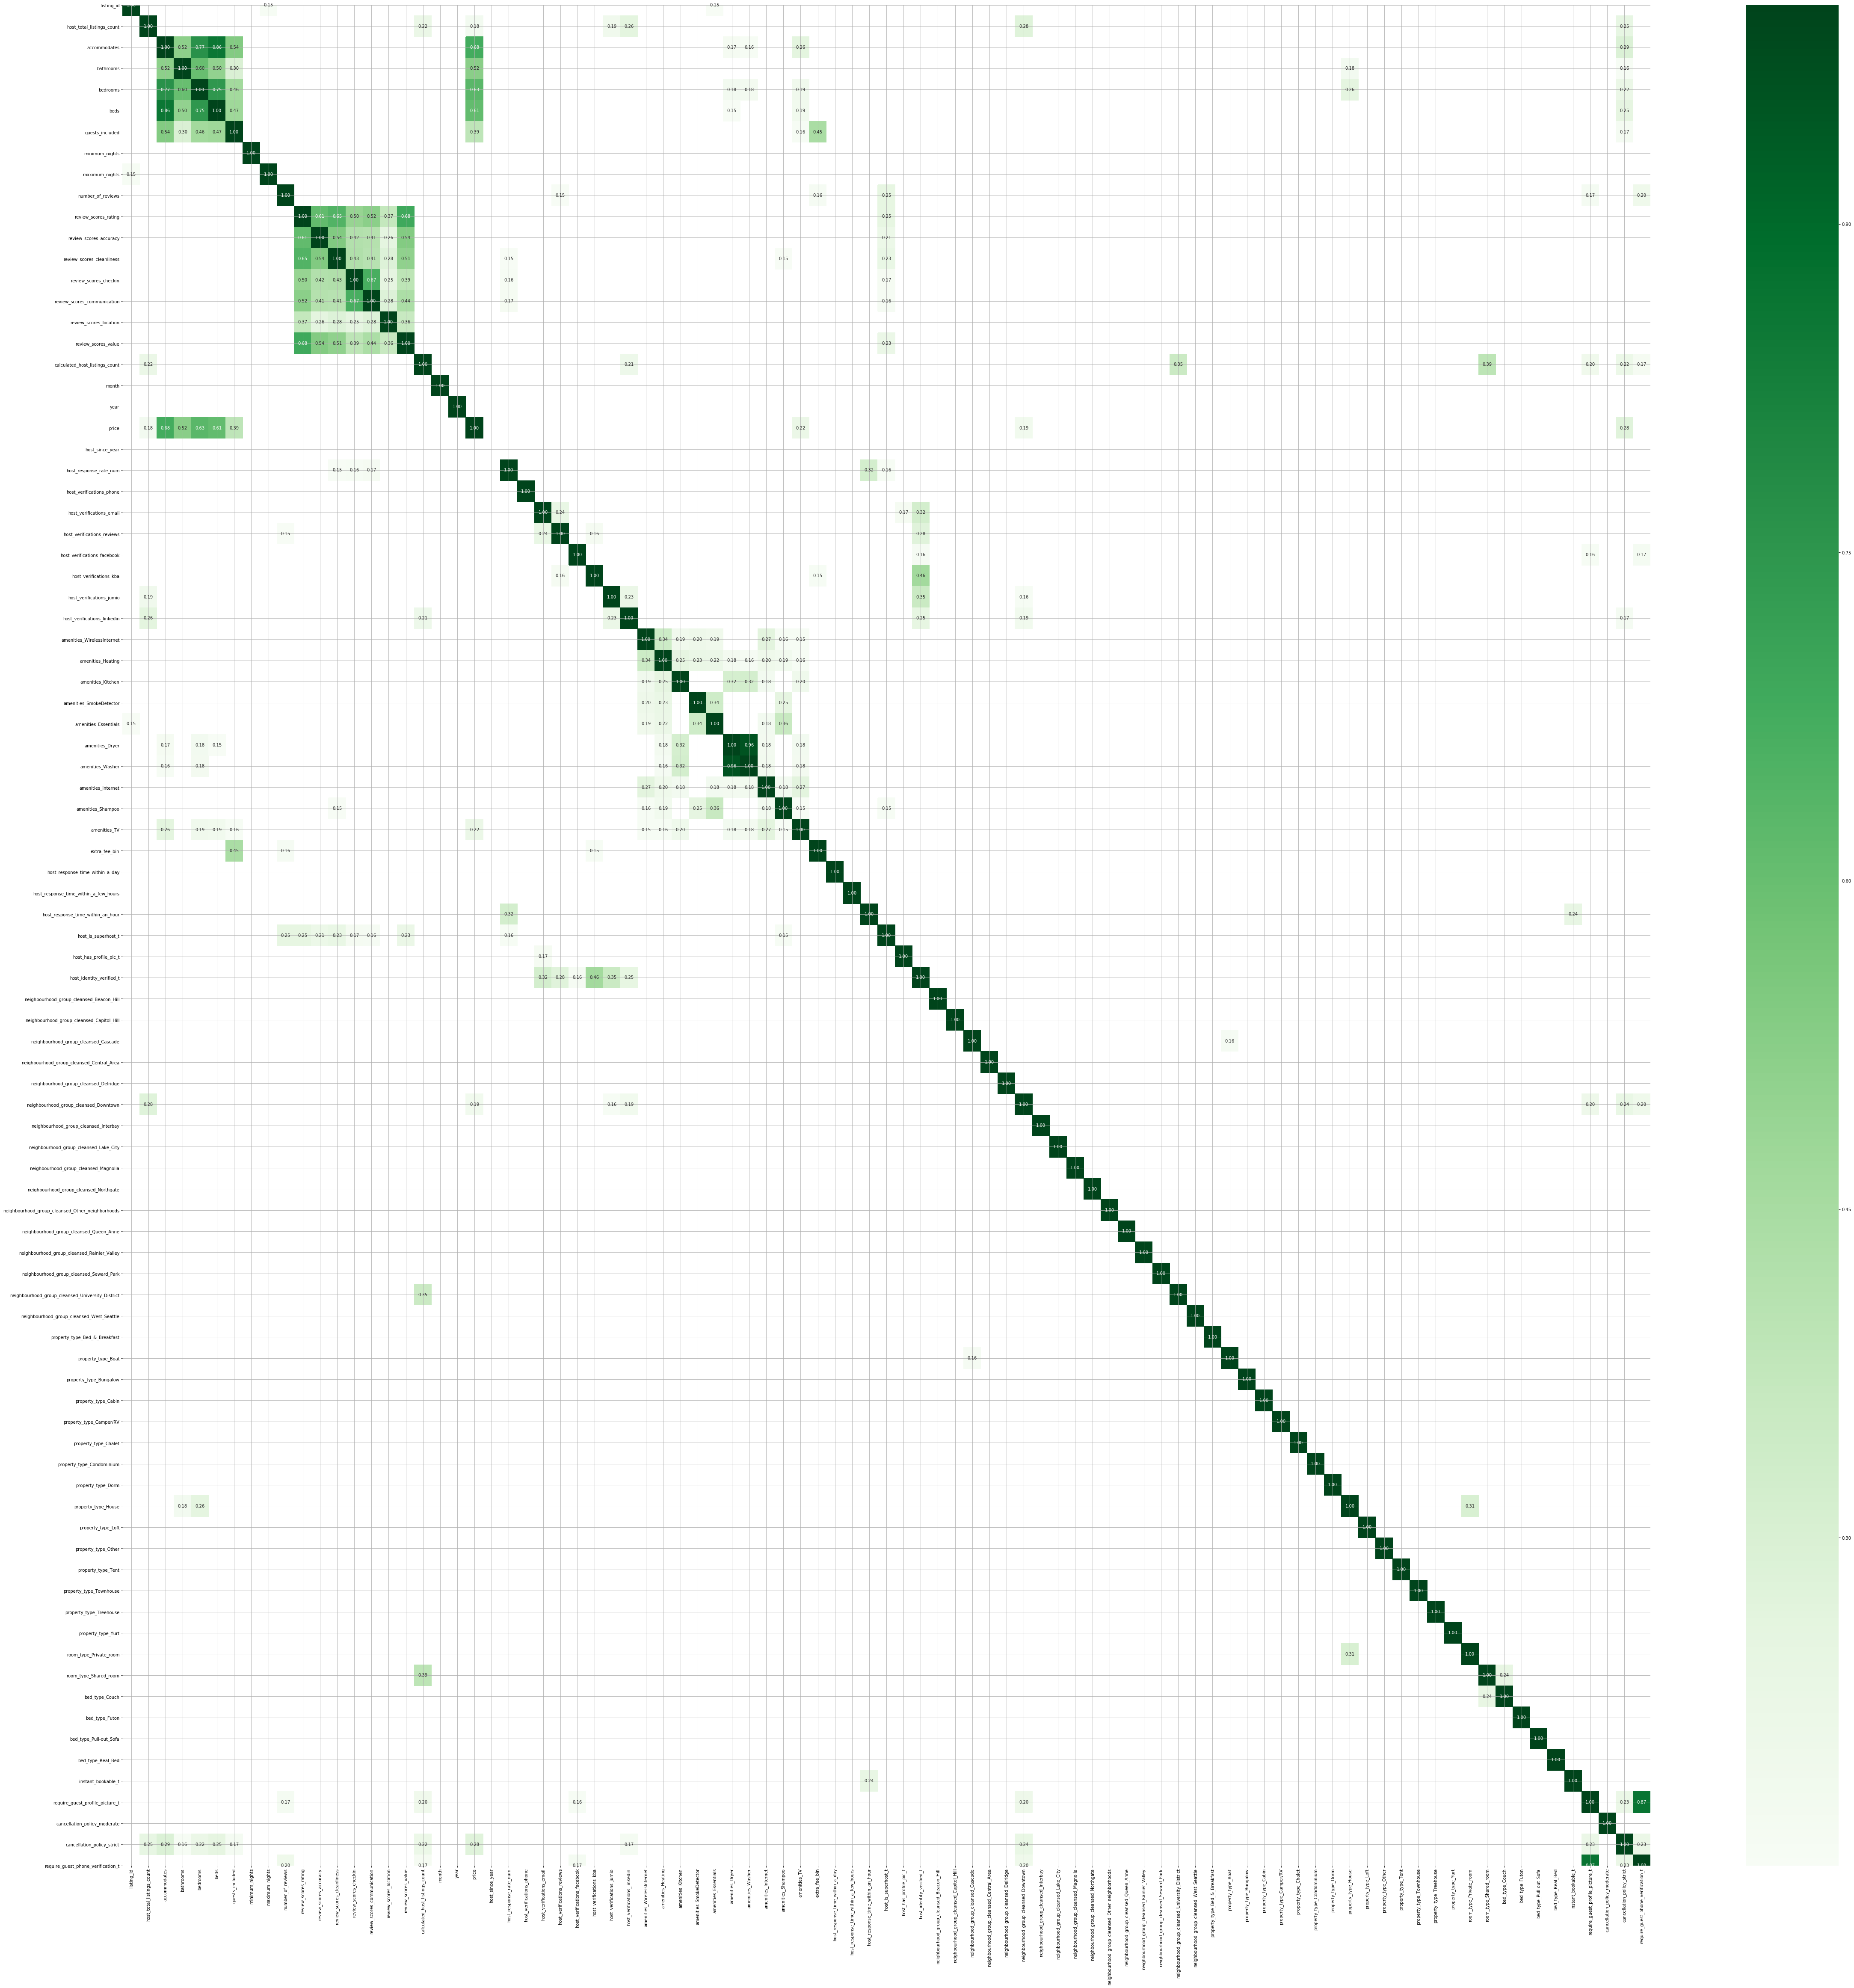

In [7]:
plt.figure(figsize=(80,80))
corr = df_data.corr()
#sns.heatmap(df_data.select_dtypes(include=['float', 'int']).dropna(how='all', axis=1).corr(), annot=True, fmt=".2f")
ax = sns.heatmap(corr[corr>0.15], annot=True, fmt=".2f", cmap='Greens')
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.savefig('./Images/Corr1.jpg')

1. What are the factors influence the price and correlation 

In [8]:
print('Maximum price in whole dataset is {}'.format(df_data.price.max()))
print('Minimum price in whole dataset is {}'.format(df_data.price.min()))
print('Average price in whole dataset is {}'.format(df_data.price.mean()))

Maximum price in whole dataset is 1650.0
Minimum price in whole dataset is 10.0
Average price in whole dataset is 137.94485855103355


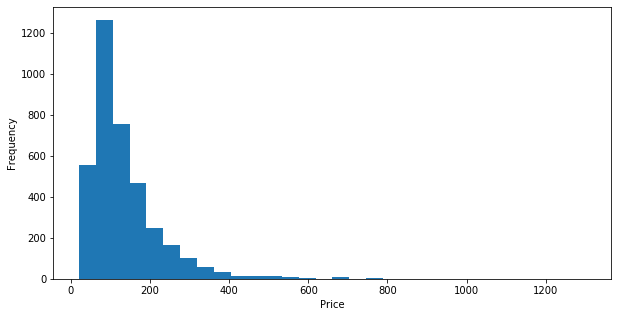

In [21]:
# Plot the histogram of average price of listing
plt.figure(figsize=(10,5))
avg_price_listing = df_data.groupby('listing_id').mean()['price'].plot.hist(bins=30)
plt.xlabel('Price')
plt.savefig('./Images/Hist.jpg', dpi=300)

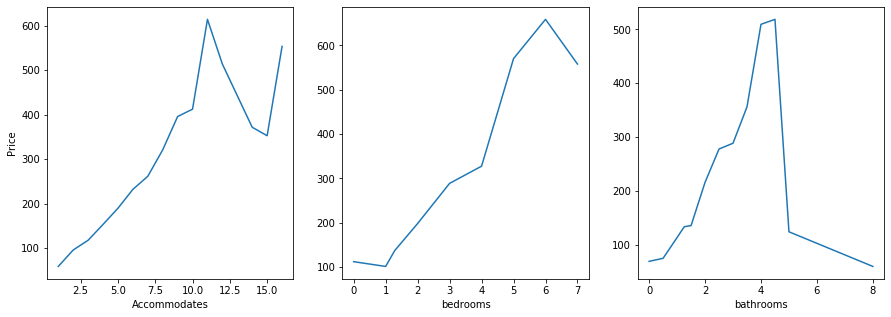

In [10]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax[0].plot(df_data.groupby('accommodates').mean()['price'])
ax[0].set(xlabel='Accommodates')
ax[0].set(ylabel='Price')
ax[1].plot(df_data.groupby('bedrooms').mean()['price'])
ax[1].set(xlabel='bedrooms')
ax[2].plot(df_data.groupby('bathrooms').mean()['price'])
ax[2].set(xlabel='bathrooms')

plt.savefig('./Images/Price.jpg', dpi=300)
# Observation
# Number of people it could accommodates, number of bedrooms and number of beds have direct 
# almost positve influence on price


2. a). Season to visit Seattle

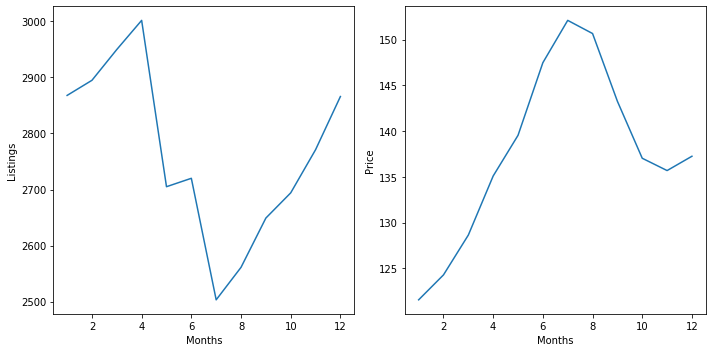

In [11]:
listing_by_month = pd.Series([12])
price_by_month = pd.Series([12])
for i in range(1, 13):
    listing_by_month[i] = len(df_data[(df_data['month']==i) & (df_data['year']==2016)]['listing_id'].unique())
    price_by_month[i] = df_data[(df_data['month']==i) & (df_data['year']==2016)]['price'].mean()

    
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax[0].plot(listing_by_month.drop(0))
ax[0].set(xlabel='Months')
ax[0].set(ylabel='Listings')
ax[1].plot(price_by_month.drop(0))
ax[1].set(ylabel='Price')
ax[1].set(xlabel='Months')
fig.tight_layout()
plt.savefig('./Images/Seasons_to_visit.jpg', dpi=300)

# Observation
# Listings are supposedly high during peak seasons of Dec-Apr but is less in summer
# But Price seems to be peak during summer and cheap during Winter season

2. b). Response Rate during Seasons

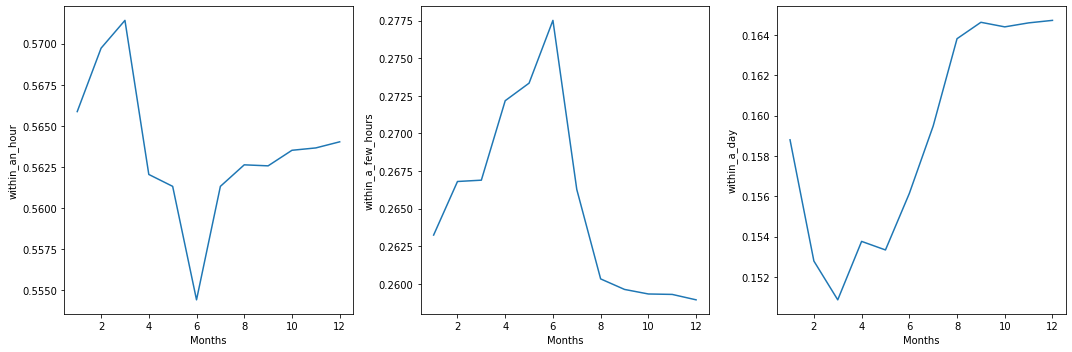

In [12]:
resp_hour_by_month = pd.Series([12])
resp_few_hour_by_month = pd.Series([12])
resp_day_by_month = pd.Series([12])
for i in range(1, 13):
    resp_hour_by_month[i] = df_data[(df_data['month']==i) & (df_data['year']==2016)]['host_response_time_within_an_hour'].mean()
    resp_few_hour_by_month[i] = df_data[(df_data['month']==i) & (df_data['year']==2016)]['host_response_time_within_a_few_hours'].mean()
    resp_day_by_month[i] = df_data[(df_data['month']==i) & (df_data['year']==2016)]['host_response_time_within_a_day'].mean()

    
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax[0].plot(resp_hour_by_month.drop(0))
ax[0].set(ylabel='within_an_hour')
ax[0].set(xlabel='Months')
ax[1].plot(resp_few_hour_by_month.drop(0))
ax[1].set(ylabel='within_a_few_hours')
ax[1].set(xlabel='Months')
ax[2].plot(resp_day_by_month.drop(0))
ax[2].set(ylabel='within_a_day')
ax[2].set(xlabel='Months')
fig.tight_layout()
plt.savefig('./Images/Response_rate.jpg', dpi=300)

# Observation
# Interesting that during peak winter season, response with an hour is not the highest but 
# response within a day is the highest, should possibly give information about winter is busy

3. Factors influence on Review Scores (Random Analysis)

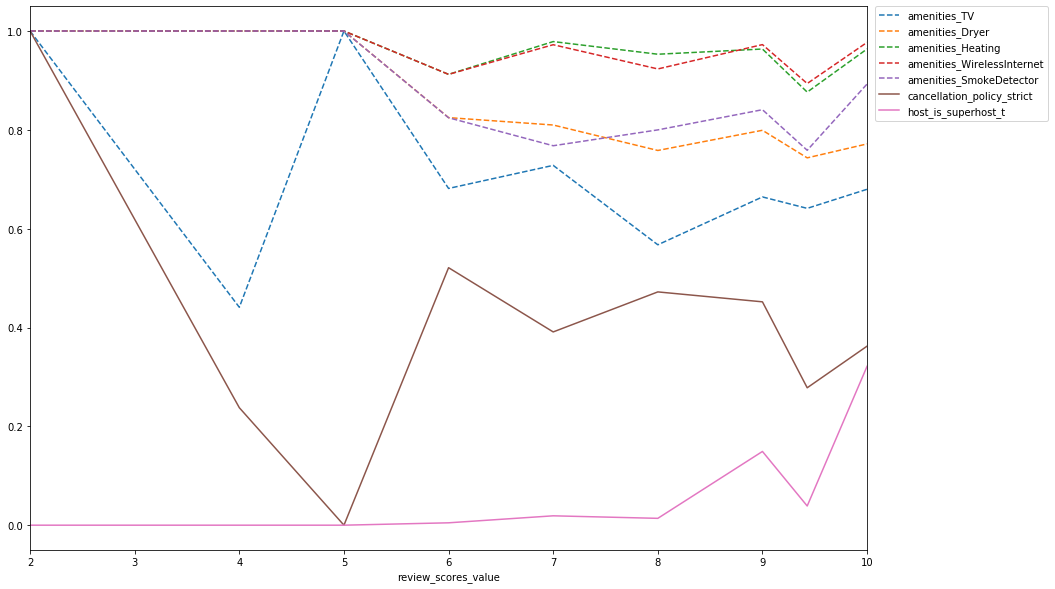

In [13]:
plt.figure(figsize=(15,10))
df_data.groupby('review_scores_value').mean()['amenities_TV'].plot(legend=True, style='--')
df_data.groupby('review_scores_value').mean()['amenities_Dryer'].plot(legend=True, style='--')
df_data.groupby('review_scores_value').mean()['amenities_Heating'].plot(legend=True, style='--')
df_data.groupby('review_scores_value').mean()['amenities_WirelessInternet'].plot(legend=True, style='--')
df_data.groupby('review_scores_value').mean()['amenities_SmokeDetector'].plot(legend=True, style='--')
df_data.groupby('review_scores_value').mean()['cancellation_policy_strict'].plot(legend=True)
ax = df_data.groupby('review_scores_value').mean()['host_is_superhost_t'].plot(legend=True)
ax.legend(bbox_to_anchor=(1.01,1), loc=2, borderaxespad=0.)
plt.savefig('./Images/Review_score.jpg', dpi=300, bbox_inches='tight')

In [ ]:
df_data.info()

Machine learning and Prediction

In [14]:
test_size = 0.3
X = df_data.drop(columns=col_ohe)
X = X.drop(columns=['listing_id', 'year', 'price'])
y = df_data['price']

# Split X & y to test and train data 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)


In [15]:
def plot_top_coeff(df, filename=None):
    '''
    input  - df: Dataframe with columns and feature coeffs ; ['name', 'coeff']
    '''
    features = df['name'][:15]
    y_pos = np.arange(len(features))
    score = df['coeff'][:15]
    
    plt.figure(figsize=(10,7.5))
    plt.bar(y_pos, score, align='center', alpha=0.5)
    plt.gcf().subplots_adjust(bottom=0.5)
    plt.xticks(y_pos, features, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Score')
    
    if filename != None:
        plt.savefig(filename)
        
    plt.show()
    return

Linear Regression

The r-squared score for your model was 0.6237298992532272 on 280363 values.


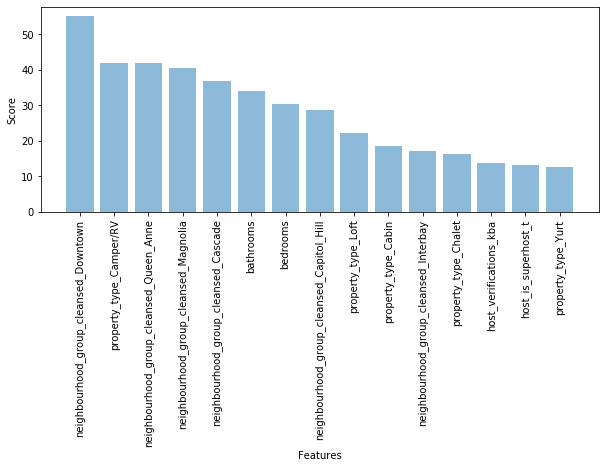

In [16]:
# Linear Regression
def coeff_wgts(lm, X_train):
    '''
    input - lm: Linear Model 
            X_Train: Training Dataframe
    output - df_coeff: sorted coeff weigts of columns
    '''
    df_coeff = pd.DataFrame()
    df_coeff['name'] = X_train.columns
    df_coeff['coeff'] = lm.coef_
    df_coeff['abs_coeff'] =np.abs(lm.coef_)
    df_coeff = df_coeff.sort_values('coeff', ascending=False)
    return df_coeff
    

lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train)

y_test_preds = lm.predict(X_test)
y_train_preds = lm.predict(X_train)
print("The r-squared score for your model was {} on {} values.".format(r2s(y_test, y_test_preds), len(y_test)))

df_lm_coeff = coeff_wgts(lm, X_train)
plot_top_coeff(df_lm_coeff[1:], './Images/LRM.jpg')

Random Forest Regression

In [17]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42)
rf.fit(X_train, y_train)

yrf_test_preds = rf.predict(X_test)
yrf_train_preds = rf.predict(X_train)
print("The r-squared score for your model was {} on {} values.".format(r2s(y_test, yrf_test_preds), len(y_test)))

The r-squared score for your model was 0.9805758678538004 on 280363 values.


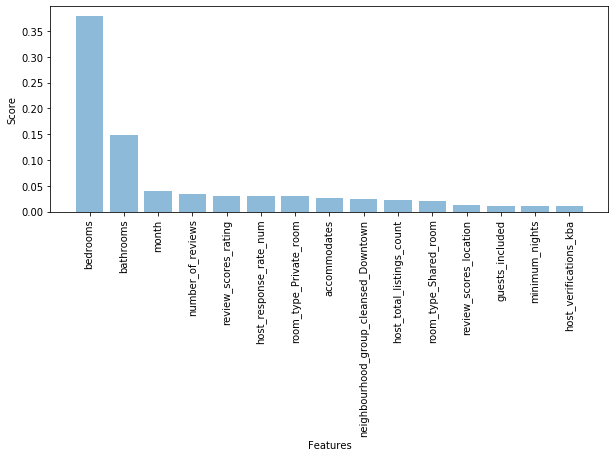

In [18]:
headers = ['name', 'coeff']
values = sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1]*-1)
df_rf_coeff = pd.DataFrame(values, columns=headers)
df_rf_coeff = df_rf_coeff.sort_values('coeff', ascending=False)
plot_top_coeff(df_rf_coeff, './Images/RFR.jpg')